<center><h1>EE69205: Signal Processing System Design</h1></center>
<center><h2>Exp-4: Bearing Fault Diagnosis using Signal Processing</h2></center>
<center><h3>Anirvan Krishna | 21EE38002<h3></center>

In [1]:
import numpy as np
from scipy import signal, io, stats
import matplotlib.pyplot as plt

In [2]:
# Load the .mat file
data_irf = io.loadmat(
    'RollingElementBearingFaultDiagnosis-Data-master\\train_data\\InnerRaceFault_vload_2.mat'
    )

data_orf = io.loadmat(
    'RollingElementBearingFaultDiagnosis-Data-master\\train_data\\OuterRaceFault_2.mat'
    )

data_baseline = io.loadmat(
    'RollingElementBearingFaultDiagnosis-Data-master\\train_data\\baseline_2.mat'
    )

# Dataset Initialization and Visualization

Each data set contains an acceleration signal $ g_s $, sampling rate $ sr $, shaft speed $ fr $, load weight $ load $,
and four critical frequencies representing different fault locations: ballpass frequency outer race (BPFO),
ballpass frequency inner race (BPFI), fundamental train frequency (FTF), and ball spin frequency (BSF).
Here are the formulae for those critical frequencies:

**Ballpass frequency, outer race (BPFO)**

$$
\text{BPFO} = \frac{n \cdot fr}{2} \left( 1 - \frac{d}{D} \cos \phi \right)
$$

**Ballpass frequency, inner race (BPFI)**

$$
\text{BPFI} = \frac{n \cdot fr}{2} \left( 1 + \frac{d}{D} \cos \phi \right)
$$

**Fundamental train frequency (FTF)**, also known as cage speed

$$
\text{FTF} = \frac{fr}{2} \left( 1 - \frac{d}{D} \cos \phi \right)
$$

**Ball (roller) spin frequency (BSF)**

$$
\text{BSF} = \frac{D \cdot fr}{2d} \left[ 1 - \left( \frac{d}{D} \cos \phi \right)^2 \right]
$$

Where $ d $ is the ball diameter, $ D $ is the pitch diameter. The variable $ fr $ is the shaft speed, $ n $ is the number
of rolling elements, and $ \phi $ is the bearing contact angle.

In [3]:
data_irf

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Jan 17 13:09:36 2013',
 '__version__': '1.0',
 '__globals__': [],
 'bearing': array([[(array([[25]], dtype=uint8), array(['50'], dtype='<U2'), array([[0.5449125],
                [0.4420854],
                [0.2165203],
                ...,
                [2.495626 ],
                [3.599049 ],
                [2.444384 ]]), array([[48828]], dtype=uint16))                       ]],
       dtype=[('rate', 'O'), ('load', 'O'), ('gs', 'O'), ('sr', 'O')]),
 'FTF': array([[14.8375]]),
 'BPFO': array([[81.125]]),
 'BPFI': array([[118.875]]),
 'BSF': array([[63.91]])}

In [4]:
data_orf

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Jan 17 13:17:26 2013',
 '__version__': '1.0',
 '__globals__': [],
 'bearing': array([[(array([[25]], dtype=uint8), array([[270]], dtype=uint16), array([[ 0.3083091],
                [-0.1723548],
                [ 0.8998852],
                ...,
                [ 0.3001135],
                [-0.946561 ],
                [-0.9734369]]), array([[97656]]))                                       ]],
       dtype=[('rate', 'O'), ('load', 'O'), ('gs', 'O'), ('sr', 'O')]),
 'FTF': array([[14.8375]]),
 'BPFO': array([[81.125]]),
 'BPFI': array([[118.875]]),
 'BSF': array([[63.91]])}

In [5]:
data_baseline

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Jan 17 13:07:20 2013',
 '__version__': '1.0',
 '__globals__': [],
 'bearing': array([[(array([[97656]]), array([[ 0.3685337],
                [-0.3983136],
                [-1.303466 ],
                ...,
                [-0.3402303],
                [ 1.109699 ],
                [ 1.013209 ]]), array([[270]], dtype=uint16), array([[25]], dtype=uint8))]],
       dtype=[('sr', 'O'), ('gs', 'O'), ('load', 'O'), ('rate', 'O')]),
 'FTF': array([[14.8375]]),
 'BPFO': array([[81.125]]),
 'BPFI': array([[118.875]]),
 'BSF': array([[63.91]])}

In [6]:
rate_irf = data_irf['bearing'][0][0][0][0]
load_irf = data_irf['bearing'][0][0][1][0]
gs_irf = data_irf['bearing'][0][0][2]
sr_irf = data_irf['bearing'][0][0][3][0]

rate_orf = data_orf['bearing'][0][0][0][0]
load_orf = data_orf['bearing'][0][0][1][0]
gs_orf = data_orf['bearing'][0][0][2]
sr_orf = data_orf['bearing'][0][0][3][0]

rate_baseline = data_baseline['bearing'][0][0][3][0]
load_baseline = data_baseline['bearing'][0][0][2][0]
gs_baseline = data_baseline['bearing'][0][0][1]
sr_baseline = data_baseline['bearing'][0][0][1][0]

In [7]:
# These parameters are same for both irf and orf
ftf = data_irf['FTF'][0]
bpfo = data_irf['BPFO'][0][0]
bpfi = data_irf['BPFI'][0][0]
bsf = data_irf['BSF'][0]

In [8]:
gs_irf.shape

(146484, 1)

In [9]:
gs_orf.shape

(585936, 1)

In [10]:
gs_baseline

array([[ 0.3685337],
       [-0.3983136],
       [-1.303466 ],
       ...,
       [-0.3402303],
       [ 1.109699 ],
       [ 1.013209 ]])

### Time Domain Plot

Text(0.5, 1.0, 'Baseline Signal')

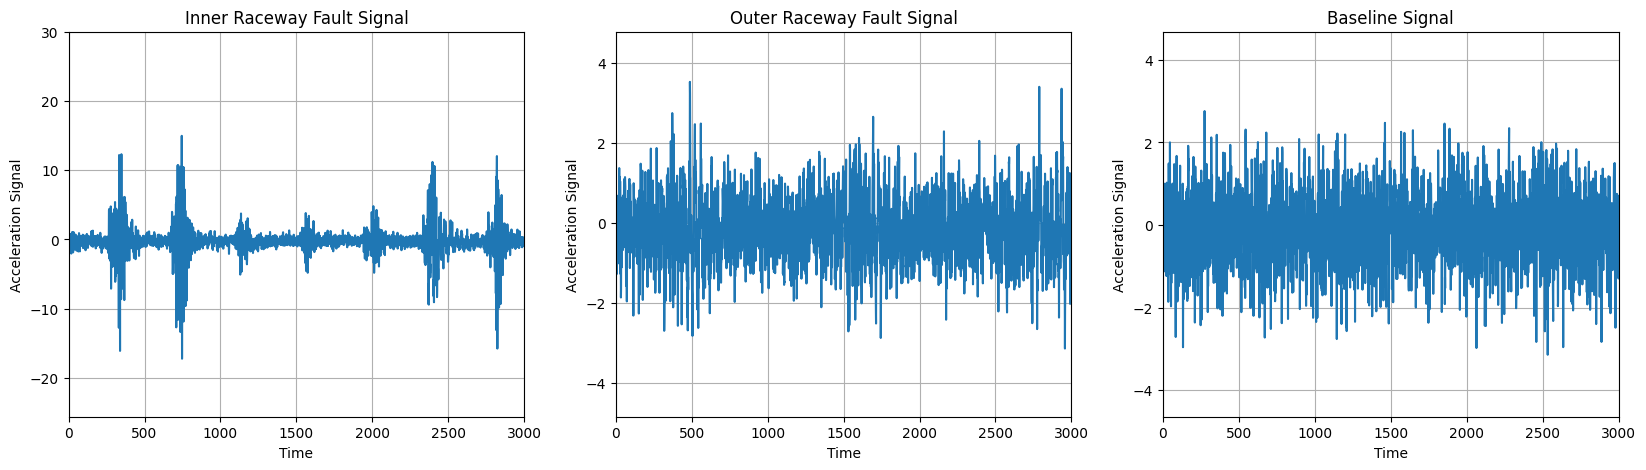

In [11]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(gs_irf)
plt.grid()
plt.xlim(0, 3000)
plt.xlabel('Time')
plt.ylabel('Acceleration Signal')
plt.title("Inner Raceway Fault Signal")

plt.subplot(1, 3, 2)
plt.plot(gs_orf)
plt.grid()
plt.xlim(0, 3000)
plt.xlabel('Time')
plt.ylabel('Acceleration Signal')
plt.title("Outer Raceway Fault Signal")

plt.subplot(1, 3, 3)
plt.plot(gs_baseline)
plt.grid()
plt.xlim(0, 3000)
plt.xlabel('Time')
plt.ylabel('Acceleration Signal')
plt.title("Baseline Signal")

## Frequency Domain Analysis

### Fast Fourier Transform

The Fast Fourier Transform (FFT) is an efficient algorithm for computing the Discrete Fourier Transform (DFT) of a sequence or signal. It is widely used in various signal processing applications, including frequency analysis, filtering, and spectral estimation.

The DFT of a sequence of N complex numbers x[n] is defined as:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j2\pi kn/N}
$$

where X[k] represents the k-th frequency component of the signal.

The FFT algorithm exploits the symmetry properties of the DFT to reduce the number of computations required. It divides the input sequence into smaller sub-sequences and recursively computes their DFTs. This divide-and-conquer approach significantly reduces the computational complexity from $O(N^2)$ to $O(N \log N)$.

To perform the FFT, we can use the `numpy.fft.fft()` function in Python or a custom function like the one below. Here's an example code snippet:

In [12]:
def fft_radix4(signal, fs):
    """
    Implementing the radix-4 FFT

    Input:
        signal: The input signal
        fs: sampling frequency

    Output:
        freq: The frequency axis
        mag: The magnitude of the FFT
        phase: The phase of fft
    """

    N = len(signal)
    freq = np.fft.fftfreq(N, 1/fs)
    signal_fft = np.zeros(N, dtype=np.complex64)

    # Radix-4 FFT implementation
    for k in range(N//4):
        for m in range(4):
            for n in range(4):
                signal_fft[4*k + m] += signal[4*k + n] * np.exp(-2j * np.pi * m * n / N)

    coeff = signal_fft
    phase = np.angle(signal_fft)

    return freq, coeff, phase

#### Frequency Domain Representation

In [13]:
## ORF Analysis
frequencies_orf, coeff_orf, phase_orf = fft_radix4(gs_orf, sr_orf)
# Shift both frequency and magnitude for proper visualization
fft_freq_shifted_orf = np.fft.fftshift(frequencies_orf)
fft_coeff_shifted_orf = np.fft.fftshift(coeff_orf)

## Baseline Analysis
frequencies_baseline, coeff_baseline, phase_baseline = fft_radix4(
    gs_baseline, sr_baseline)
# Shift both frequency and magnitude for proper visualization
fft_freq_shifted_baseline = np.fft.fftshift(frequencies_baseline)
fft_coeff_shifted_baseline = np.fft.fftshift(coeff_baseline)

## IRF Analysis
frequencies_irf, coeff_irf, phase_irf = fft_radix4(gs_irf, sr_irf)
# Shift both frequency and magnitude for proper visualization
fft_freq_shifted_irf = np.fft.fftshift(frequencies_irf)
fft_coeff_shifted_irf = np.fft.fftshift(coeff_irf)

Text(0.5, 1.0, 'Frequency Spectrum of Normal Condition')

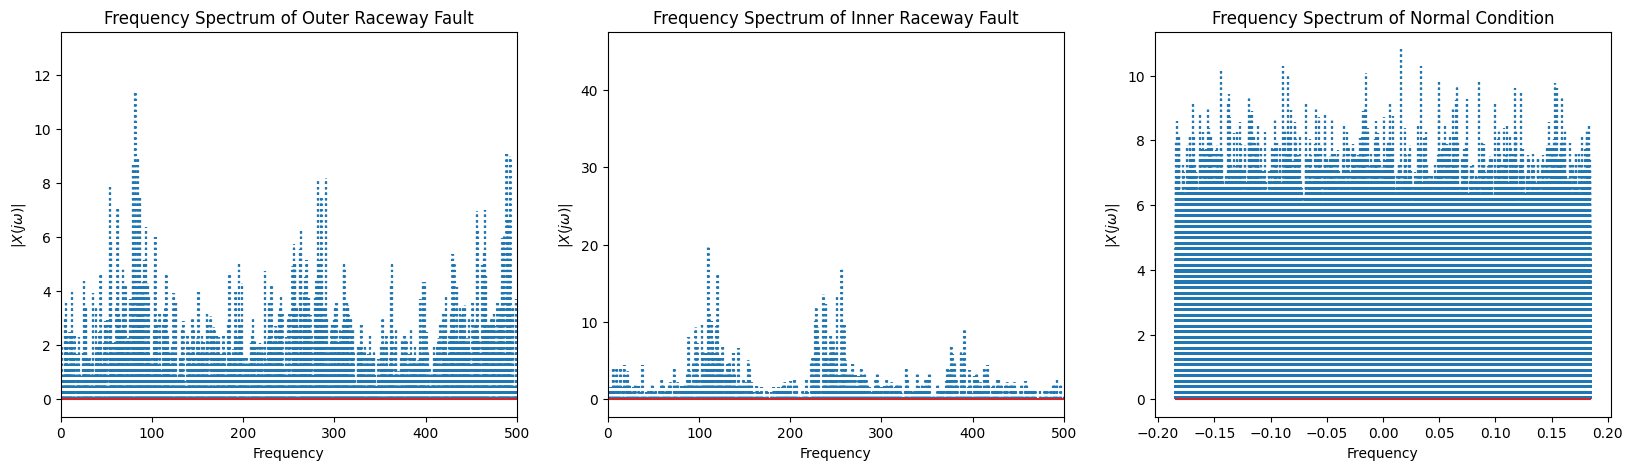

In [14]:
plt.figure(figsize=(20, 5))

## Plot ORF Signal
plt.subplot(1, 3, 1)
plt.stem(fft_freq_shifted_orf, np.abs(fft_coeff_shifted_orf), linefmt=':', markerfmt="")
plt.xlim(0, 500)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Frequency Spectrum of Outer Raceway Fault')

## Plot IRF Signal
plt.subplot(1, 3, 2)
plt.stem(fft_freq_shifted_irf, np.abs(
    fft_coeff_shifted_irf), linefmt=':', markerfmt="")
plt.xlim(0, 500)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Frequency Spectrum of Inner Raceway Fault')

## Plot Baseline Signal
plt.subplot(1, 3, 3)
plt.stem(fft_freq_shifted_baseline, np.abs(
    fft_coeff_shifted_baseline), linefmt=':', markerfmt="")
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Frequency Spectrum of Normal Condition')

### Short-Time Fourier Transform

The Short-Time Fourier Transform (STFT) is a time-frequency analysis technique used to analyze non-stationary signals. It provides a way to examine the frequency content of a signal over time by dividing the signal into short overlapping windows and calculating the Fourier Transform for each window.

The STFT is defined as follows:

$$
X(t, \omega) = \int_{-\infty}^{\infty} x(\tau) \cdot w(t - \tau) \cdot e^{-j\omega\tau} \, d\tau
$$

where $x(t)$ is the input signal, $w(t)$ is a window function, $\omega$ is the angular frequency, and $X(t, \omega)$ represents the time-frequency representation of the signal.

By applying the STFT, we can obtain a spectrogram, which is a 2D representation of the signal's frequency content over time. The magnitude of the STFT represents the signal's energy at different frequencies and time instants, while the phase provides information about the signal's phase relationships.

In [15]:
def stft(signal, fs, window_size):
    """
    Implementing the Short-Time Fourier Transform (STFT)

    Input:
        signal: The input signal
        fs: Sampling frequency
        window_size: Size of the time window for STFT

    Output:
        freq: The frequency axis
        mag: The magnitude of the STFT
        phase: The phase of the STFT
    """

    # Calculate the number of samples in each window
    window_samples = int(fs * window_size)

    # Calculate the number of overlapping samples
    overlap_samples = int(window_samples / 2)

    # Calculate the number of windows
    num_windows = int(
        np.ceil((len(signal) - overlap_samples) / (window_samples - overlap_samples)))

    # Pad the signal with zeros to ensure all windows have the same length
    padded_signal = np.pad(signal, (0, window_samples + (num_windows - 1)
                           * overlap_samples - len(signal)), 'constant')

    # Initialize arrays to store the magnitude and phase of the STFT
    mag = np.zeros((num_windows, window_samples))
    phase = np.zeros((num_windows, window_samples))

    # Calculate the STFT for each window
    for i in range(num_windows):
        # Extract the current window from the padded signal
        start_index = i * overlap_samples
        end_index = start_index + window_samples

        if end_index > len(padded_signal):
            end_index = len(padded_signal)
            start_index = end_index - window_samples

        window = padded_signal[start_index:end_index]

        if len(window) != window_samples:
            window = np.pad(window, (0, window_samples - len(window)), 'constant')

        # Apply the window function to the windowed signal
        windowed_signal = window * np.hanning(window_samples)

        # Compute the Fourier transform of the windowed signal
        windowed_fft = np.fft.fft(windowed_signal)

        # Calculate the magnitude and phase of the Fourier transform
        mag[i] = np.abs(windowed_fft)
        phase[i] = np.angle(windowed_fft)

    # Calculate the frequency axis
    freq = np.fft.fftfreq(window_samples, 1 / fs)

    return freq, mag, phase

Text(0.5, 0, 'Time [s]')

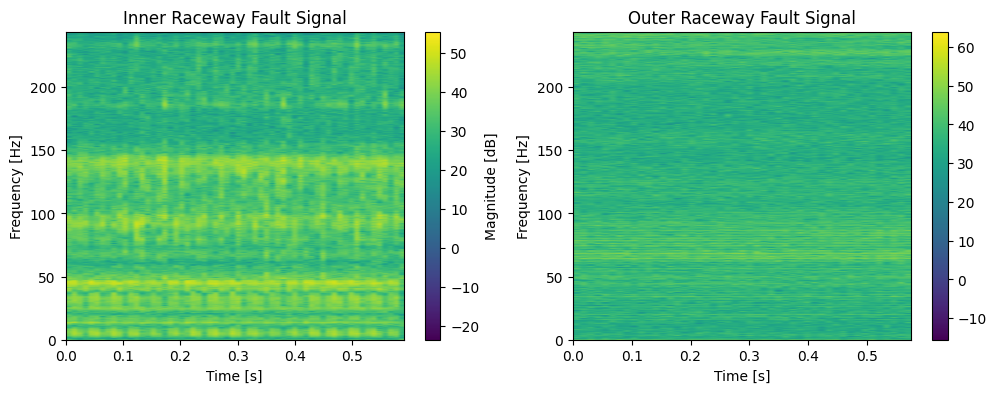

In [16]:
# STFT parameters
window_size = 0.1  # Window size in seconds

# Compute the STFT for IRF
freq_irf, mag_irf, phase_irf = stft(gs_irf.reshape(gs_irf.shape[0]), sr_irf, window_size)

# Time axis
time_irf = np.arange(mag_irf.shape[0]) * (window_size / 2)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs_irf = freq_irf[:len(freq_irf)//2]
mag_irf = mag_irf[:, :len(freq_irf)//2]

# Plot the spectrogram using imshow
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(20 * np.log10(mag_irf.T), aspect='auto', origin='lower',
           extent=[time_irf.min(), time_irf.max()/5, positive_freqs_irf.min(), positive_freqs_irf.max()//100],)
plt.title('Inner Raceway Fault Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude [dB]')

##########################################

## Spectrogram Computation for ORF
window_size = 0.25

# Compute the STFT for IRF
freq_orf, mag_orf, phase_orf = stft(
    gs_orf.reshape(gs_orf.shape[0]), sr_orf, window_size)

# Time axis
time_orf = np.arange(mag_orf.shape[0]) * (window_size / 2)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs_orf = freq_orf[:len(freq_irf)//2]
mag_orf = mag_orf[:, :len(freq_irf)//2]

plt.subplot(1, 2, 2)
plt.imshow(20 * np.log10(mag_orf.T), aspect='auto', origin='lower',
           extent=[time_orf.min(), time_orf.max()/10, positive_freqs_orf.min(), positive_freqs_orf.max()//40],)
plt.title('Outer Raceway Fault Signal')
plt.ylabel('Frequency [Hz]')
plt.colorbar()
plt.xlabel('Time [s]')

# Signal Filtering: Bandpass FIR Filter

A bandpass filter is a type of filter that allows a specific range of frequencies, known as the passband, to pass through while attenuating frequencies outside the passband. FIR bandpass filters are designed to selectively filter out unwanted frequencies and retain the desired frequency range.

The general equation for an FIR filter can be represented as:

$$
y[n] = \sum_{k=0}^{N-1} h[k] \cdot x[n-k]
$$

where:
- $y[n]$ is the output sample at time index $n$
- $x[n-k]$ is the input sample at time index $n-k$
- $h[k]$ is the filter coefficient at index $k$
- $N$ is the filter order

To design a bandpass filter, we need to determine the filter coefficients $h[k]$ that define the desired frequency response. The frequency response of an FIR filter can be obtained by taking the Discrete Fourier Transform (DFT) of the filter coefficients.

Once the cutoff frequencies are determined, the filter coefficients can be calculated using various filter design techniques, such as the window method or the Parks-McClellan algorithm.

In [17]:
print(f"BPFO: {bpfo} Hz | BPFI: {bpfi} Hz")

BPFO: 81.125 Hz | BPFI: 118.875 Hz


In [18]:
def bandpass_fir_filter(x, low, high, sampling_rate, order):

    x = x.flatten()
    # Normalize the cutoff frequencies
    low_norm = low / (sampling_rate / 2)
    high_norm = high / (sampling_rate / 2)

    # Design the FIR filter
    taps = signal.firwin(order, [low_norm, high_norm], pass_zero=False, fs=sampling_rate, window='hamming')

    # Apply the FIR filter to the signal
    filtered_signal = signal.lfilter(taps, [1.0], x)

    return filtered_signal

Application on Inner Raceway Fault

In [55]:
sr_irf

array([48828], dtype=uint16)

In [84]:
filtered_signal_irf = bandpass_fir_filter(gs_irf, 500, 1000, 
                                          sampling_rate=sr_irf[0], order=55)

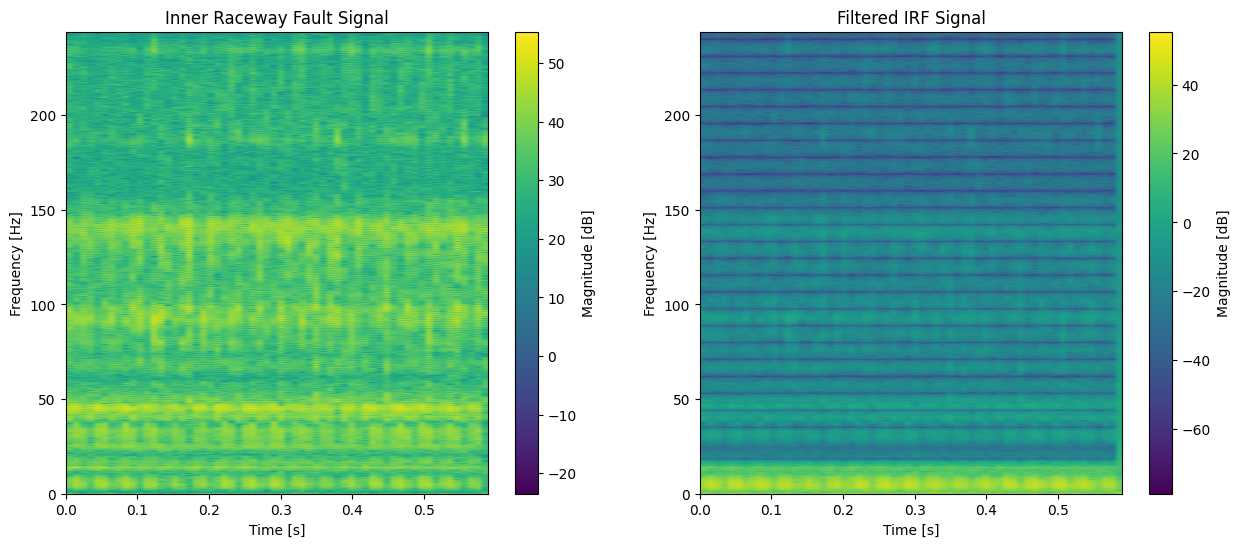

In [85]:
plt.figure(figsize=(15, 6))

# STFT parameters
window_size = 0.1  # Window size in seconds

# Compute the STFT
freq, mag, phase = stft(gs_irf.reshape(gs_irf.shape[0]), sr_irf, window_size)

# Time axis
time = np.arange(mag.shape[0]) * (window_size / 2)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs = freq[:len(freq)//2]
mag = mag[:, :len(freq)//2]

# Plot the spectrogram using imshow
plt.subplot(1, 2, 1)
plt.imshow(20 * np.log10(mag.T), aspect='auto', origin='lower',
           extent=[time.min(), time.max()/5, positive_freqs.min(), positive_freqs.max()/100])
plt.title('Inner Raceway Fault Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude [dB]')

# Plot Filtered Signal
freq, mag, phase = stft(filtered_signal_irf.reshape(filtered_signal_irf.shape[0]), sr_irf, window_size)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs = freq[:len(freq)//2]
mag = mag[:, :len(freq)//2]
plt.subplot(1, 2, 2)
plt.imshow(20 * np.log10(mag.T), aspect='auto', origin='lower',
           extent=[time.min(), time.max()/5, positive_freqs.min(), positive_freqs.max()/100])
plt.title('Original Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Filtered IRF Signal')
plt.colorbar(label='Magnitude [dB]')
plt.show()

Text(0.5, 1.0, 'Band-Pass Filtered IRF Signal')

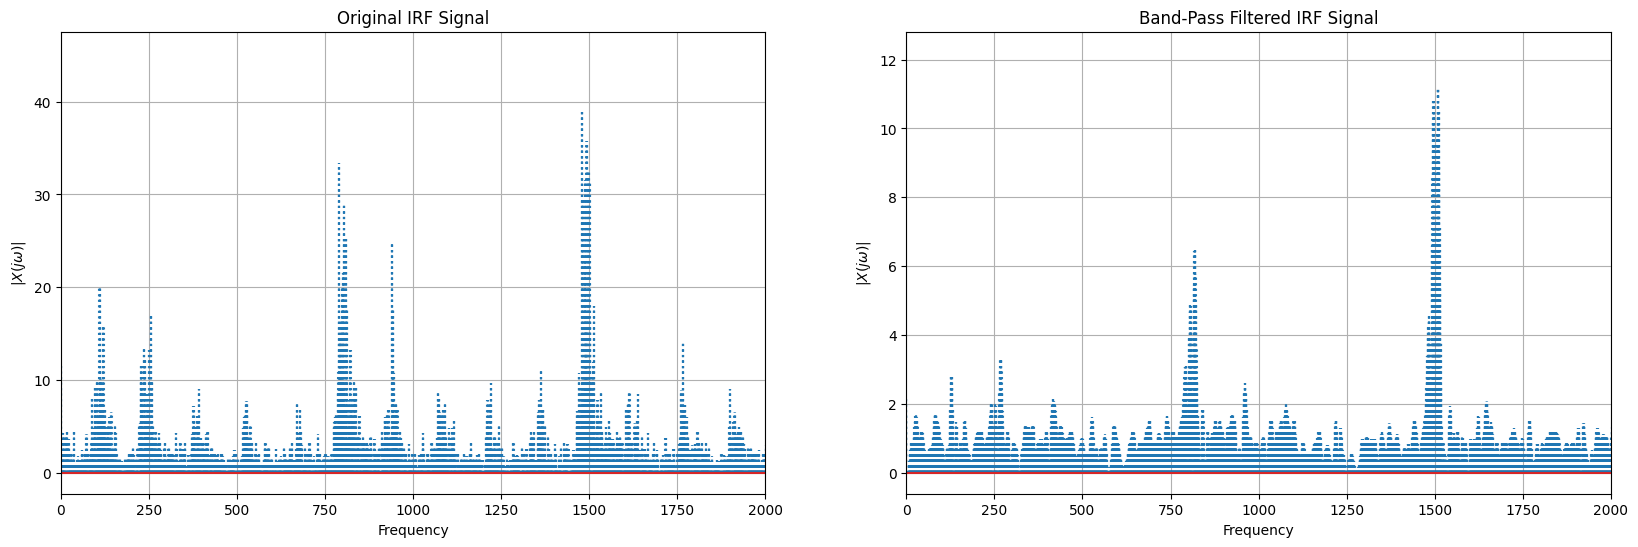

In [86]:
frequency, coeff, phase = fft_radix4(gs_irf, sr_irf)

# Shift both frequency and magnitude for proper visualization
fft_freq_shifted = np.fft.fftshift(frequency)
fft_coeff_shifted = np.fft.fftshift(coeff)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.stem(fft_freq_shifted, np.abs(fft_coeff_shifted), markerfmt="", linefmt=":")
plt.grid()
plt.xlim(0, 2000)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Original IRF Signal')

frequency, coeff, phase = fft_radix4(filtered_signal_irf, sr_irf)

# Shift both frequency and magnitude for proper visualization
fft_freq_shifted = np.fft.fftshift(frequency)
fft_coeff_shifted = np.fft.fftshift(coeff)

plt.subplot(1, 2, 2)
plt.stem(fft_freq_shifted, np.abs(fft_coeff_shifted), markerfmt="", linefmt=":")
plt.grid()
plt.xlim(0, 2000)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Band-Pass Filtered IRF Signal')

Application on Outer-Raceway Fault

In [66]:
filtered_signal_orf = bandpass_fir_filter(gs_orf, 2300, 3040, 
                                          sampling_rate=sr_orf[0], order=55)

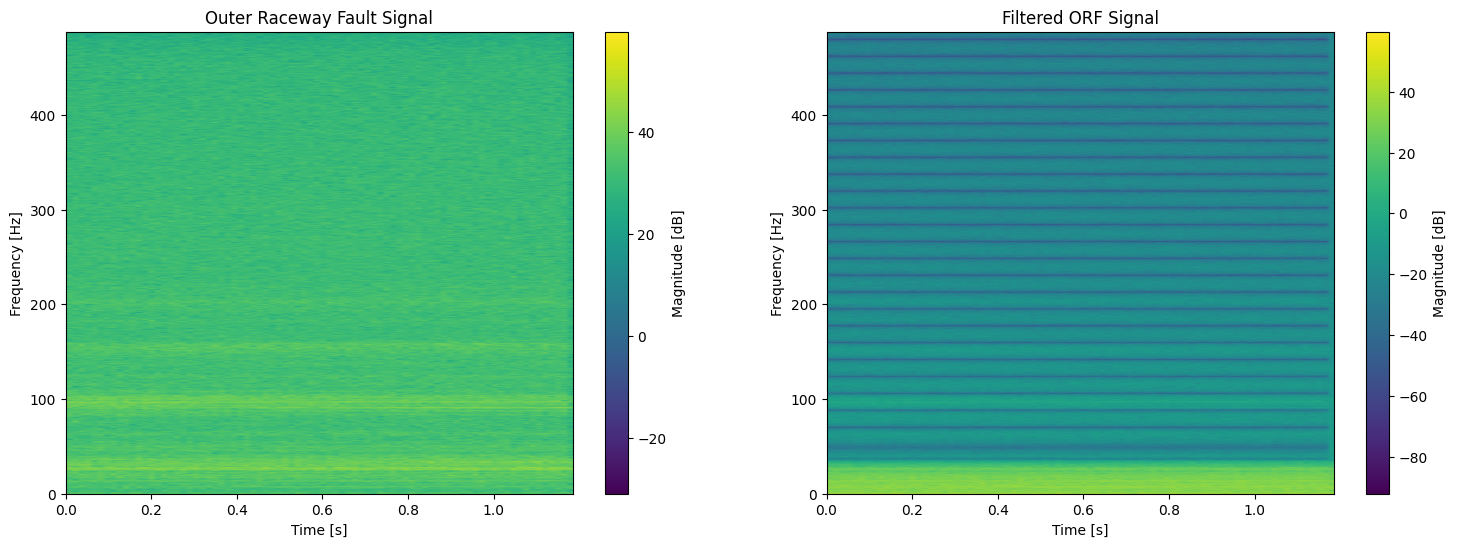

In [67]:
plt.figure(figsize=(18, 6))

# STFT parameters
window_size = 0.15  # Window size in seconds

# Compute the STFT
freq, mag, phase = stft(gs_orf.reshape(gs_orf.shape[0]), sr_orf, window_size)

# Time axis
time = np.arange(mag.shape[0]) * (window_size / 2)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs = freq[:len(freq)//2]
mag = mag[:, :len(freq)//2]

# Plot the spectrogram using imshow
plt.subplot(1, 2, 1)
plt.imshow(20 * np.log10(mag.T), aspect='auto', origin='lower',
           extent=[time.min(), time.max()/5, positive_freqs.min(), positive_freqs.max()//100])
plt.title('Outer Raceway Fault Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude [dB]')

# Plot Filtered Signal
freq, mag, phase = stft(filtered_signal_orf.reshape(filtered_signal_orf.shape[0]), sr_orf, window_size)

# Only plot positive frequencies (up to Nyquist frequency)
positive_freqs = freq[:len(freq)//2]
mag = mag[:, :len(freq)//2]
plt.subplot(1, 2, 2)
plt.imshow(20 * np.log10(mag.T), aspect='auto', origin='lower',
           extent=[time.min(), time.max()/5, positive_freqs.min(), positive_freqs.max()//100])
plt.title('Original Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Filtered ORF Signal')
plt.colorbar(label='Magnitude [dB]')
plt.show()

Text(0.5, 1.0, 'Band-Pass Filtered ORF Signal')

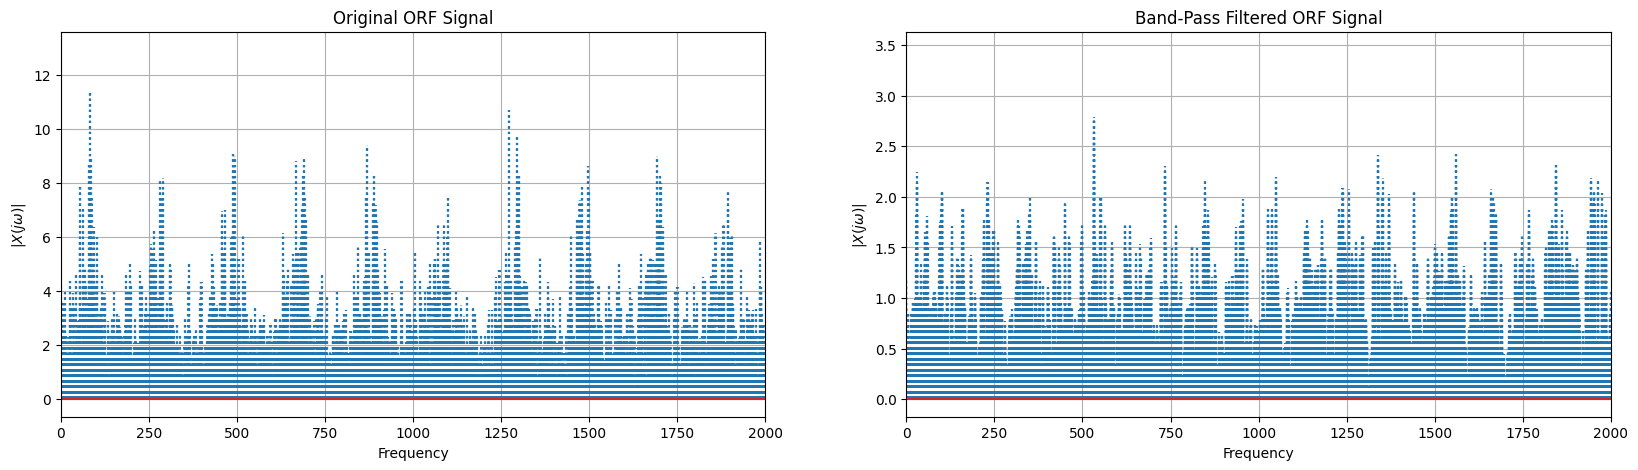

In [68]:
frequency, coeff, phase = fft_radix4(gs_orf, sr_orf)

# Shift both frequency and magnitude for proper visualization
fft_freq_shifted = np.fft.fftshift(frequency)
fft_coeff_shifted = np.fft.fftshift(coeff)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.stem(fft_freq_shifted, np.abs(fft_coeff_shifted), markerfmt="", linefmt=":")
plt.grid()
plt.xlim(0, 2000)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Original ORF Signal')

frequency, coeff, phase = fft_radix4(filtered_signal_orf, sr_irf)

# Shift both frequency and magnitude for proper visualization
fft_freq_shifted = np.fft.fftshift(frequency)
fft_coeff_shifted = np.fft.fftshift(coeff)

plt.subplot(1, 2, 2)
plt.stem(fft_freq_shifted, np.abs(fft_coeff_shifted), markerfmt="", linefmt=":")
plt.grid()
plt.xlim(0, 2000)
plt.xlabel('Frequency')
plt.ylabel('$|X(j\omega)|$')
plt.title('Band-Pass Filtered ORF Signal')

# Hilbert Transform and Envelope Formation

The Hilbert Transform is a mathematical operation that is used to analyze and manipulate signals in the time-frequency domain. It is particularly useful in signal processing applications that involve the analysis of non-stationary signals.

The Hilbert Transform is defined as follows:

$$
\mathcal{H}(x(t)) = \frac{1}{\pi} \text{P.V.} \int_{-\infty}^{\infty} \frac{x(\tau)}{t - \tau} \, d\tau
$$

where $\mathcal{H}(x(t))$ represents the Hilbert Transform of the input signal $x(t)$, and $\text{P.V.}$ denotes the Cauchy principal value of the integral.

The Hilbert Transform introduces a phase shift of $90 \degree$ to the input signal, effectively shifting the signal's spectrum by $90$ degrees. This allows us to extract the instantaneous amplitude and phase information of the signal.

The Hilbert Transform can be used to calculate the analytic signal, which is a complex-valued representation of the input signal. The analytic signal is defined as:

$$
z(t) = x(t) + j \cdot \mathcal{H}(x(t))
$$

where $j$ represents the imaginary unit.

The magnitude of the analytic signal represents the instantaneous amplitude of the signal, while the phase represents the instantaneous phase. By calculating the Hilbert Transform and extracting the magnitude and phase of the analytic signal, we can analyze the time-varying characteristics of the signal in the frequency domain.

In the context of the ongoing task, the Hilbert Transform can be applied to the signal data to extract additional information about the bearing fault diagnosis. By calculating the Hilbert Transform of the signal and analyzing the magnitude and phase of the resulting analytic signal, we can gain insights into the instantaneous amplitude and phase characteristics of the signal, which can be useful for identifying and diagnosing bearing faults.

In [25]:
def hilbert_transform(signal):
    N = len(signal)
    
    # Step 1: Compute the FFT of the input signal
    fft_signal = np.fft.fft(signal)
    
    # Step 2: Create the Hilbert transform filter (1D array)
    H = np.zeros(N)
    
    H[0] = 1
    H[1:(N+1)//2] = 2

    # Step 4: Compute the inverse FFT to get the Hilbert transformed signal
    hilbert_signal = np.fft.ifft(fft_signal * H)
    
    # The real part is the original signal, and the imaginary part is the Hilbert transform
    analytic_signal = signal + 1j * hilbert_signal
    
    return hilbert_signal, analytic_signal

In [26]:
# def hilbert_transform(x):
#     N = len(x)
#     X = np.fft.fft(x)
#     h = np.zeros(N)
#     h[0] = 1
#     h[1:(N+1)//2] = 2
#     h[(N+1)//2:] = 0
#     out = np.fft.ifft(X*h)
#     return out, X + 1j * out

Envelope for Inner Raceway Fault

Text(0.5, 1.0, 'Baseline Signal and its Envelope')

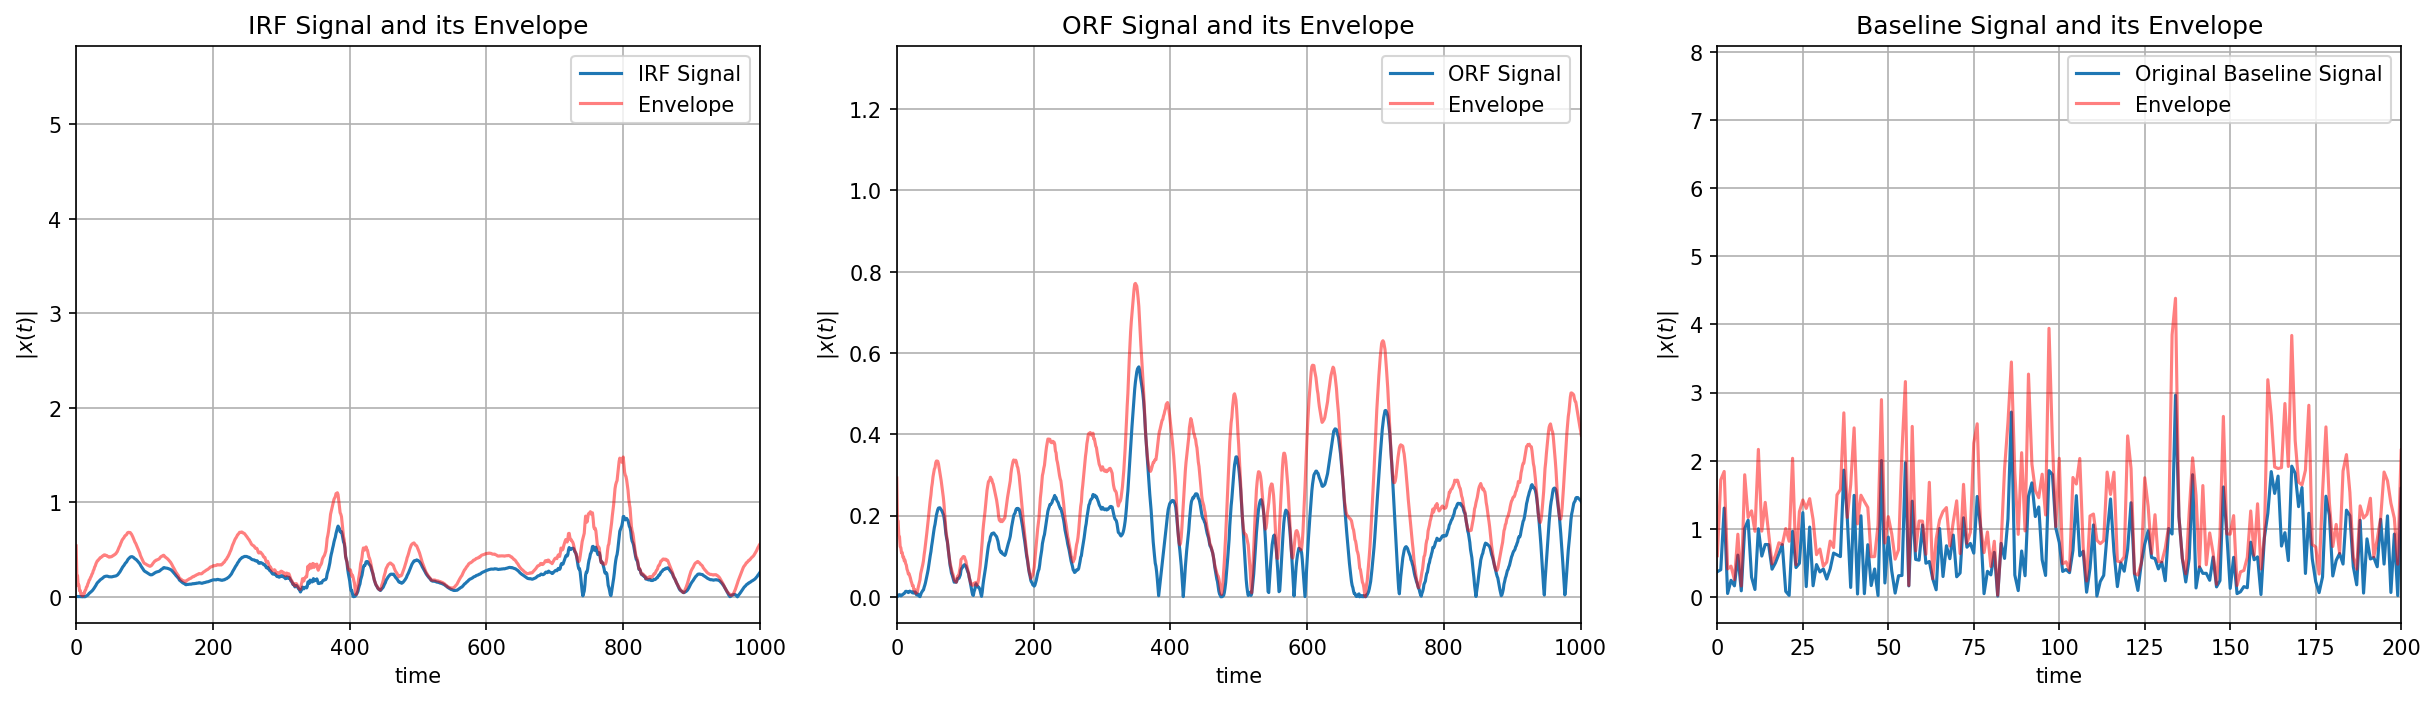

In [87]:
hilbert_signal_irf, analytic_signal_irf = hilbert_transform(filtered_signal_irf)
irf_envelope = np.abs(analytic_signal_irf)

plt.figure(figsize=(20, 5), dpi=150)

## Envelope for IRF Signal
plt.subplot(1, 3, 1)
plt.plot(np.abs(filtered_signal_irf), label = 'IRF Signal')
plt.plot(irf_envelope, label = 'Envelope', c='red', alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(0, 1000)
plt.xlabel('time')
plt.ylabel('$|x(t)|$')
plt.title('IRF Signal and its Envelope')

## Envelope for ORF Signal
hilbert_signal_orf, analytic_signal_orf = hilbert_transform(
    filtered_signal_orf)
orf_envelope = np.abs(analytic_signal_orf)

plt.subplot(1, 3, 2)
plt.plot(np.abs(filtered_signal_orf), label='ORF Signal')
plt.plot(orf_envelope, label='Envelope', c='red', alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(0, 1000)
plt.xlabel('time')
plt.ylabel('$|x(t)|$')
plt.title('ORF Signal and its Envelope')


## Envelope for Baseline Signal
hilbert_signal_baseline, analytic_signal_baseline = hilbert_transform(
    gs_baseline.flatten())
baseline_envelope = np.abs(analytic_signal_baseline)

plt.subplot(1, 3, 3)
plt.plot(np.abs(gs_baseline), label='Original Baseline Signal')
plt.plot(baseline_envelope, label='Envelope', c='red', alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(0, 200)
plt.xlabel('time')
plt.ylabel('$|x(t)|$')
plt.title('Baseline Signal and its Envelope')

# One Sided Power Spectrum Computation

The one-sided power spectrum is a mathematical representation of the power distribution of a signal in the frequency domain. It provides information about the strength of different frequency components present in the signal.

To compute the one-sided power spectrum, we can follow these steps:

1. Start with the magnitude spectrum of the signal, which represents the amplitude of each frequency component. Let's denote it as `magnitude`.

2. Square the magnitude spectrum element-wise to obtain the power spectrum. This step is necessary because power is proportional to the square of the amplitude. Let's denote the power spectrum as `power`.

    ```python
    power = magnitude ** 2
    ```

3. Normalize the power spectrum by dividing it by the total number of samples in the signal. This step ensures that the power values are independent of the signal length. Let's denote the normalized power spectrum as `power_normalized`.

    ```python
    power_normalized = power / len(signal)
    ```

4. Compute the one-sided power spectrum by taking the first half of the power spectrum, excluding the DC component (frequency 0) and the negative frequencies. This step is possible because the power spectrum is symmetric around the DC component.

    ```python
    one_sided_power_spectrum = power_normalized[1:len(power_normalized) // 2]
    ```

The resulting `one_sided_power_spectrum` represents the power distribution of the signal in the frequency domain, excluding the negative frequencies.

By analyzing the one-sided power spectrum, we can identify the dominant frequency components in the signal and gain insights into its frequency content.

In [28]:
def compute_one_sided_power_spectrum(signal, fs):
    # Step 1: Compute the magnitude spectrum of the signal
    magnitude = np.abs(np.fft.fft(signal))

    # Step 2: Square the magnitude spectrum to obtain the power spectrum
    power = magnitude ** 2

    # Step 3: Normalize the power spectrum
    power_normalized = power / len(signal)

    # Step 4: Compute the one-sided power spectrum
    one_sided_power_spectrum = power_normalized[1:len(power_normalized) // 2]

    # Compute the corresponding frequency axis
    freq = np.fft.fftfreq(len(signal), 1 / fs)
    one_sided_freq = freq[1:len(freq) // 2]

    return one_sided_power_spectrum, one_sided_freq

Applications on Outer-Racway Fault

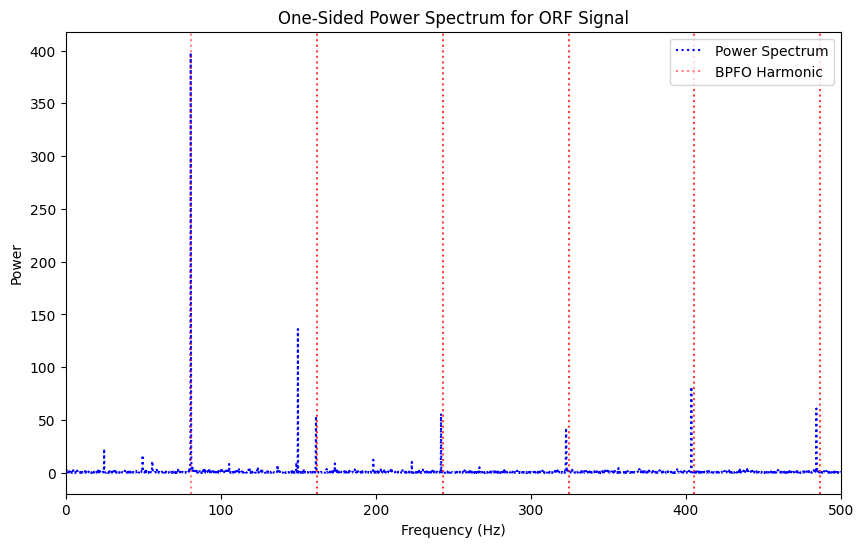

In [29]:
# Compute the one-sided power spectrum for the analytic signal
power_spectrum, freq = compute_one_sided_power_spectrum(orf_envelope, sr_orf)

# Plot the one-sided power spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum, color='blue', linestyle=':', label='Power Spectrum')
plt.xlim(0, 500)

# Add vertical dashed lines at integer multiples of BPFO
bpfo_multiples = np.arange(1, int(np.ceil(freq.max() / bpfo)) + 1)

# Add a label only for the first line, omit it for the rest
for i, multiple in enumerate(bpfo_multiples):
    if i == 0:
        plt.axvline(x=bpfo * multiple, color='red',
                    linestyle=':', alpha=0.5, label='BPFO Harmonic')
    else:
        plt.axvline(x=bpfo * multiple, color='red', linestyle=':', alpha=0.75)

# Add labels to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('One-Sided Power Spectrum for ORF Signal')
plt.legend(loc='upper right')

Applications on IRF Signal

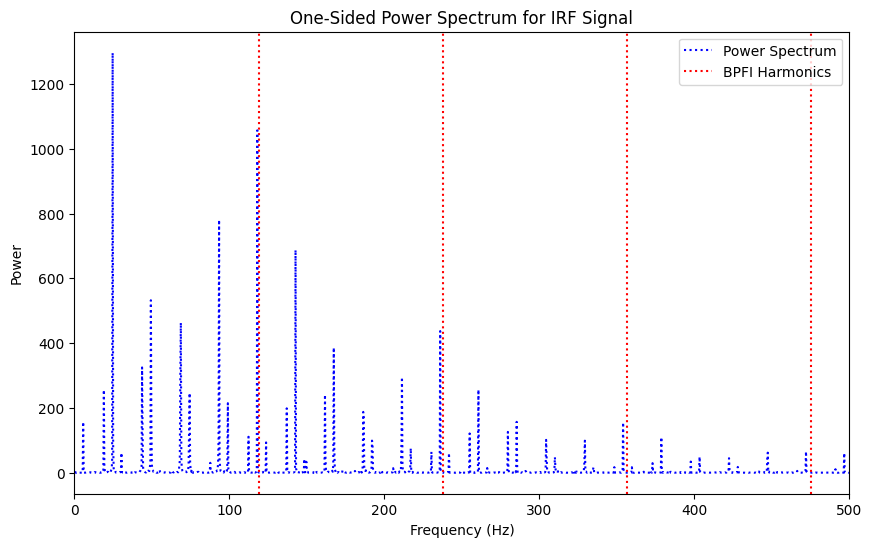

In [88]:
# Compute the one-sided power spectrum for the analytic signal
power_spectrum, freq = compute_one_sided_power_spectrum(irf_envelope, sr_irf)

# Plot the one-sided power spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum, color='blue',
          linestyle=':', label='Power Spectrum')
plt.xlim(0, 500)

# Add vertical dashed lines at integer multiples of BPFI
bpfi_multiples = np.arange(1, int(np.ceil(freq.max() / bpfi)) + 1)

for i, multiple in enumerate(bpfi_multiples):
    if i==0:
        plt.axvline(x=bpfi * multiple, color='red', linestyle=':', label='BPFI Harmonics')
    else:
        plt.axvline(x=bpfi * multiple, color='red', linestyle=':')

# Add labels to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('One-Sided Power Spectrum for IRF Signal')
plt.legend(loc='upper right')

For Baseline Signal

Text(0.5, 1.0, 'One-Sided Power Spectrum for Baseline Signal')

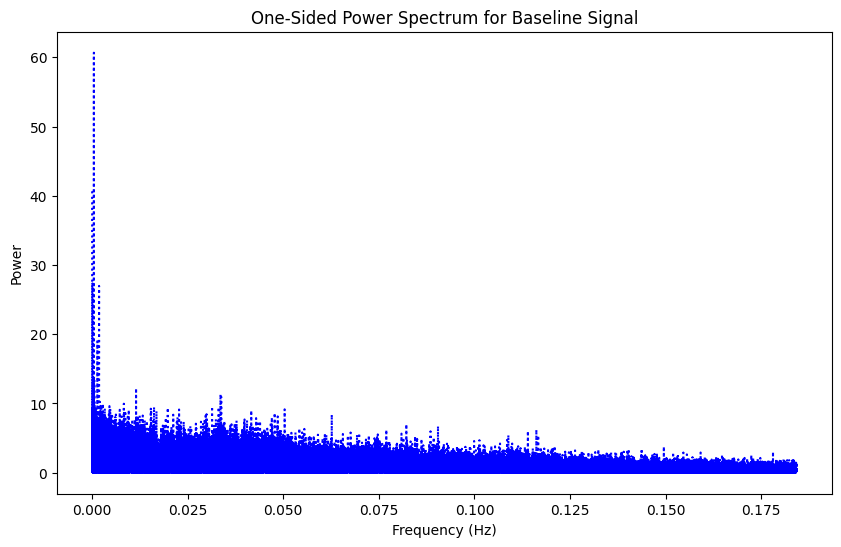

In [31]:
# Compute the one-sided power spectrum for the analytic signal
power_spectrum, freq = compute_one_sided_power_spectrum(
    baseline_envelope, sr_baseline)

# Plot the one-sided power spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum, color='blue',
         linestyle=':', label='Power Spectrum')

# Add labels to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('One-Sided Power Spectrum for Baseline Signal')

# Signal Statistics

In [32]:
print("-"*5+ " Inner Raceway Fault Statistics " + "-"*5)
print(f"\nEnvelope mean: {np.mean(irf_envelope):.4f}")
print(f"Envelope std: {np.std(irf_envelope):.4f}")
print(f"BPFI: {bpfi:.2f} Hz")
print("BPFI Harmonics:")
bpfi_harmonics = bpfi * np.arange(1, 5)
for i, harmonic in enumerate(bpfi_harmonics):
    print(f"  Harmonic {i+1}: {harmonic:.2f} Hz")

print(f"Kurtosis of the Signal: {stats.kurtosis(gs_irf)[0]: .2f}")

print("\n")
print("-"*5 + " Outer Raceway Fault Statistics " + "-"*5)
print(f"\nEnvelope mean: {np.mean(orf_envelope):.4f}")
print(f"Envelope std: {np.std(orf_envelope):.4f}")
print(f"BPFO: {bpfo:.2f} Hz")
print("BPFO Harmonics:")
bpfo_harmonics = bpfo * np.arange(1, 5)
for i, harmonic in enumerate(bpfo_harmonics):
    print(f"  Harmonic {i+1}: {harmonic:.2f} Hz")

print(f"Kurtosis of the Signal: {stats.kurtosis(gs_orf)[0]: .2f}")

print("\n")
print("-"*5 + "Baseline Signal Statistics " + "-"*5)
print(f"\nEnvelope mean: {np.mean(baseline_envelope):.4f}")
print(f"Envelope std: {np.std(baseline_envelope):.4f}")
print(f"Kurtosis of the Signal: {stats.kurtosis(gs_baseline)[0]: .2f}")

----- Inner Raceway Fault Statistics -----

Envelope mean: 0.4193
Envelope std: 0.4678
BPFI: 118.88 Hz
BPFI Harmonics:
  Harmonic 1: 118.88 Hz
  Harmonic 2: 237.75 Hz
  Harmonic 3: 356.62 Hz
  Harmonic 4: 475.50 Hz
Kurtosis of the Signal:  24.97


----- Outer Raceway Fault Statistics -----

Envelope mean: 0.2791
Envelope std: 0.1794
BPFO: 81.12 Hz
BPFO Harmonics:
  Harmonic 1: 81.12 Hz
  Harmonic 2: 162.25 Hz
  Harmonic 3: 243.38 Hz
  Harmonic 4: 324.50 Hz
Kurtosis of the Signal:  0.50


-----Baseline Signal Statistics -----

Envelope mean: 1.2829
Envelope std: 0.7976
Kurtosis of the Signal:  0.02
